Compara los métodos de regresión logística y el clasificador bayesiano ingenuo en las siguientes tareas:

* Clasificación de spam

* Clasificación de tumores de seno

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

In [ ]:
class LogisticRegression:

    def __init__(self, n_iter, alpha):
        self.n_iter = n_iter
        self.alpha = alpha
        self.scaler = MinMaxScaler()

    def fix_data(self, X):
        ones_X = np.ones((X.shape[0], 1))
        return np.column_stack((ones_X, X))

    def gradient(self, X, Y, Q):
        return X.T @  (Q - Y)

    def softmax(self, z):
        e_z = np.exp(z - np.max(z, axis = 1)[:, np.newaxis])
        norm = np.sum(e_z, axis = 1)
        return e_z / norm[:, np.newaxis]

    def cross_entropy(self,q, y):
        q[q==0] = np.nextafter(0,1)
        q[q==1] = np.nextafter(1,0)
        return np.sum(-np.log(q[np.nonzero(y)]))

    def gradient_descent(self, X, y):
        Y_k = np.zeros((self.n, self.n_classes))
        y_idx = np.array([np.argwhere(self.classes == i)[0] for i in y]).T[0]
        Y_k[np.arange(self.n), y_idx] = 1
        lim = np.sqrt(1 / self.n_attributes)
        self.parameters = np.random.uniform(-lim, lim, size=(self.n_attributes, self.n_classes))
        ecc = []
        for it in range(self.n_iter):
            Q = self.softmax(X @ self.parameters)
            self.parameters -= self.alpha * self.gradient(X, Y_k, Q)
            ecc.append(self.cross_entropy(Q, Y_k))

    def fit(self, X_train, y_train):
        X_train_sc = self.scaler.fit_transform(X_train)
        X_train_sc = self.fix_data(X_train_sc)
        self.n = X_train_sc.shape[0]
        self.n_attributes = X_train_sc.shape[1]
        self.classes = np.unique(y_train)
        self.n_classes = len(self.classes)
        self.gradient_descent(X_train_sc, y_train)

    def predict(self, X):
        X_sc = self.scaler.transform(X)
        X_sc = self.fix_data(X_sc)
        likelihood = self.softmax(X_sc @ self.parameters)
        prediction = np.argmax(likelihood, axis=1)
        y_predict = np.zeros_like(prediction)
        for i, p in enumerate(prediction):
            y_predict[i] = self.classes[p]
        return y_predict

    def score(self, X, y):
        y_predict = self.predict(X)
        return np.mean(y == y_predict)

In [ ]:
# cross validation con K particiones
def crossValidation(X, y, r=2, k=5):
  n = X.shape[0]
  t_pliegue = int(n / k)
  for i in range(r):
    perm = np.random.permutation(n)
    Xperm = X[perm]
    yperm = y[perm]
    for j in range(k):
      masc_val = np.zeros(n, dtype=bool)
      masc_val[t_pliegue*j:t_pliegue*(j+1)] = True
      masc_ent = np.logical_not(masc_val)
      X_ent = Xperm[masc_ent]
      y_ent = yperm[masc_ent]
      X_val = Xperm[masc_val]
      y_val = yperm[masc_val]

      yield i, j, i * k + j, X_ent, y_ent, X_val, y_val



# Clasificación de spam

## Carga y lectura de datos

In [ ]:
url = 'http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_automatizado/data/spam.csv'
df = pd.read_csv(url, sep=' ', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#rename the last column
df.rename(columns = {2000 : 'SPAM'}, inplace=True)

spam = len(df[df['SPAM'] == 1])
no_spam = len(df[df['SPAM'] == 0])

print(f'La cantidad de correos marcados como spam es {spam}')
print(f'Lo cual representa un porcentaje del {spam*100/(spam + no_spam)} %')
print(f'La cantidad de correos no marcados como spam es {no_spam}')
print(f'Lo cual representa un porcentaje del {no_spam*100/(spam + no_spam)} %')

La cantidad de correos marcados como spam es 1500
Lo cual representa un porcentaje del 29.00232018561485 %
La cantidad de correos no marcados como spam es 3672
Lo cual representa un porcentaje del 70.99767981438515 %


In [ ]:
X = df.loc[:, df.columns != 'SPAM'].to_numpy()
y =df['SPAM'].to_numpy()


# using the train test split function
X_train, X_test, Y_train, Y_test = train_test_split(X,y ,
                          test_size = 0.2,
                          random_state = 0,
                          train_size = 0.8, shuffle = True)



In [ ]:
print(f'El conjunto de entrenamiento tiene {len(X_train)} observaciones.')
print(f'El conjunto de validación tiene {len(X_test)} observaciones.')


El conjunto de entrenamiento tiene 4137 observaciones.
El conjunto de validación tiene 1035 observaciones.


## Spam con regresión logistica

In [ ]:
n_iter = 100    # Número de iteraciones
alphas = np.geomspace(1e-20, 1e20, num=9)    # Learning rate
r = 10  # Repeticiones
k = 5   # Particiones

score_train_LogR_spam = np.zeros((alphas.shape[0], r*k))
score_valid_LogR_spam = np.zeros((alphas.shape[0], r*k))
for idx, alp in enumerate(alphas):
    for i, j, l, x_train, y_train, x_valid, y_valid in crossValidation(X_train, Y_train, r, k):
        LogR_spam = LogisticRegression(n_iter, alp)
        LogR_spam.fit(x_train, y_train)
        score_train_LogR_spam[idx, l] = LogR_spam.score(x_train, y_train)
        score_valid_LogR_spam[idx, l] = LogR_spam.score(x_valid, y_valid)

In [ ]:
# arrays into data frame
score_train_LogR_spam = pd.DataFrame((score_train_LogR_spam).transpose())
score_valid_LogR_spam = pd.DataFrame((score_valid_LogR_spam).transpose())

In [ ]:
score_train_LogR_spam

,0,1,2,3,4,5,6,7,8
0,0.601813,0.700604,0.676435,0.721148,0.959819,0.961934,0.960725,0.951662,0.967069
1,0.309063,0.567069,0.454985,0.721752,0.958610,0.965861,0.963746,0.957704,0.954381
2,0.274924,0.715408,0.398792,0.728701,0.960423,0.954683,0.956193,0.953776,0.961027
3,0.518127,0.640181,0.670997,0.726586,0.948640,0.958308,0.962538,0.966163,0.962236
4,0.621752,0.505740,0.650453,0.723263,0.964653,0.955891,0.959819,0.962236,0.961329
5,0.651964,0.354683,0.559517,0.721450,0.960423,0.968882,0.958308,0.956193,0.956798
6,0.504532,0.428701,0.415710,0.721148,0.957100,0.958006,0.949547,0.961027,0.957402
7,0.684894,0.619940,0.419940,0.726888,0.958308,0.961934,0.956193,0.950453,0.964048
8,0.380363,0.635952,0.665257,0.723263,0.961027,0.944109,0.952870,0.959215,0.964653
9,0.309668,0.570997,0.708459,0.724471,0.962538,0.964955,0.964653,0.961329,0.956495


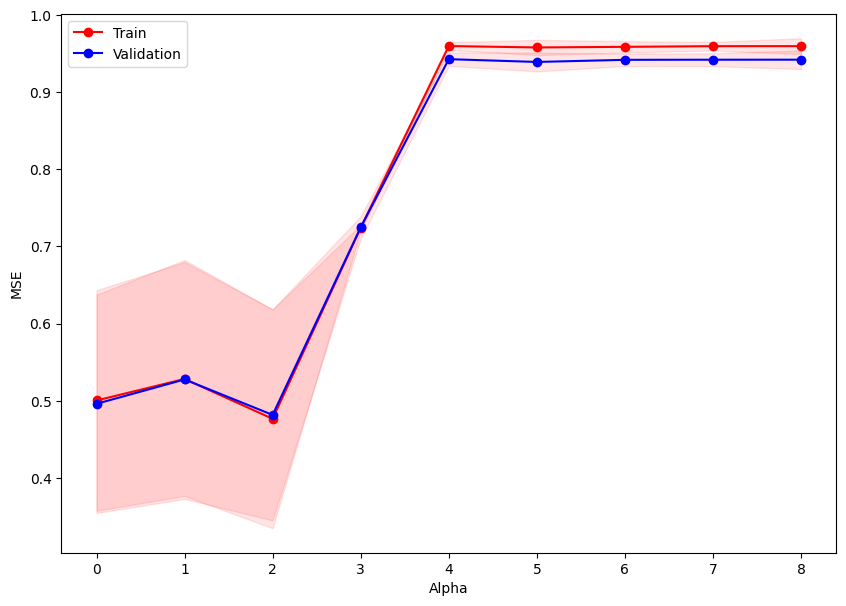

In [ ]:
#deg = list(range(degrees))

def plot_with_std(mean_squared_errors_train, mean_squared_errors_test, atributo):
  deg = list(range(len(mean_squared_errors_train.mean())))

  plt.figure(figsize=(10, 7))

  plt.fill_between(deg, mean_squared_errors_train.mean() - mean_squared_errors_train.std() , mean_squared_errors_train.mean() + mean_squared_errors_train.std(), alpha=0.1, color='r')
  plt.fill_between(deg, mean_squared_errors_test.mean() - mean_squared_errors_test.std() , mean_squared_errors_test.mean() + mean_squared_errors_test.std(), alpha=0.1, color='r')

  plt.plot(deg, mean_squared_errors_train.mean(), 'o-', color="r", label="Train")
  plt.plot(deg, mean_squared_errors_test.mean(), 'o-', color='b', label="Validation")


  plt.xlabel(atributo)
  plt.ylabel('MSE')
  plt.legend()
  plt.show()

plot_with_std(score_train_LogR_spam, score_valid_LogR_spam, 'Alpha')

Podemos observar que a partir de la 4ta alpha el rendimiento es mucho mejor, además de que la desviación estandar también decreció considerablemente. Usaremos la ultima alpha para evaluar el conjunto de validación

## Spam con naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

In [ ]:
k = 5
#RepeatedKFold hace 10 repeticiones por default

to_test =[MultinomialNB(), GaussianNB(),  BernoulliNB()]

accuracy_train = np.zeros((len(to_test), 10*k))
accuracy_test  = np.zeros((len(to_test), 10*k))

for i in range(len(to_test)):
  model = make_pipeline( MinMaxScaler(), to_test[i] )
  k_fold = RepeatedKFold(n_splits = k, random_state = 0)

  scores = cross_validate(model, X_train, Y_train,
                          scoring= 'accuracy',
                          cv = k_fold,
                          return_train_score = True,
                          error_score='raise')

  accuracy_train[i][:] = scores['train_score']
  accuracy_test[i][:]  = scores['test_score']


In [ ]:
df_accuracy_train = pd.DataFrame(accuracy_train.T, columns= ['MultinomialNB()', 'GaussianNB()',  'BernoulliNB()'])
df_accuracy_test = pd.DataFrame(accuracy_test.T, columns= ['MultinomialNB()', 'GaussianNB()',  'BernoulliNB()'])

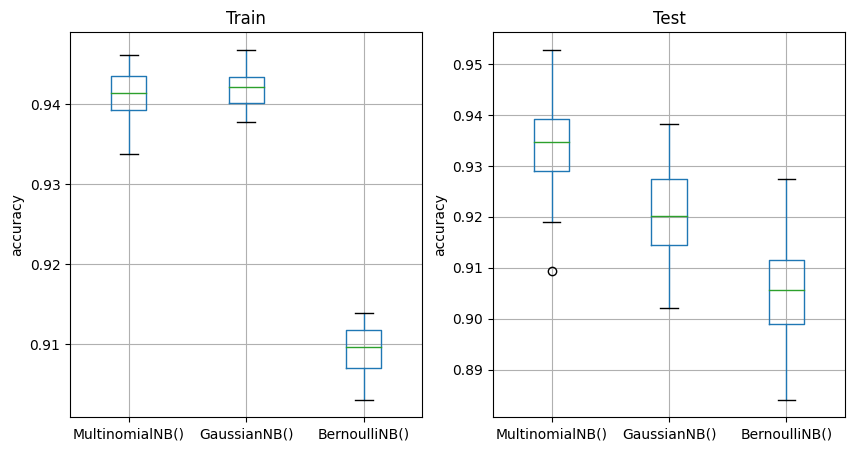

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
df_accuracy_train.boxplot()
plt.ylabel('accuracy')
plt.title('Train')

plt.subplot(1, 2, 2)
df_accuracy_test.boxplot()
plt.ylabel('accuracy')
plt.title('Test')

plt.show()

Para el caso de los clasificadores bayesianos podemos observar que en el conjunto de entrenamiento el mejor desempeño lo tiene el Gaussian y en segundo lugar el Multinomial, en todos la desviación estandar es más pequeña que la presentada en el conjunto de test. En el conjunto de test el mejor desempeño se observa en el multinomial, aunque para todos la desviación estandar es muy grande. Elegiremos multinomial como mejor modelo.

## Evaluación en el conjunto de validación
Probaremos el mejor modelo en el conjunto de validación

In [ ]:
# Naive Bayes
model = make_pipeline( MinMaxScaler(), MultinomialNB())
model.fit(X_test, Y_test)
model.score(X_test, Y_test)



0.9562043795620438

In [ ]:
# regresión logistica

best_alpha = alphas[-1]

model = make_pipeline( MinMaxScaler(), LogisticRegression(n_iter, alp))
model.fit(X_test, Y_test)
model.score(X_test, Y_test)


0.9927007299270073

Observamos que se otuvieron accurays muy similares y bastante buenas, aunque la obtenida en RL fue ligeramente mejor que la obtenida con NB Multinomial.

# Cancer de seno

## Carga y lectura de datos

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
df = pd.read_csv(url, sep=',', header=None)

#   #  Attribute                     Domain
#   -- -----------------------------------------
#   1. Sample code number            id number
#   2. Clump Thickness               1 - 10
#   3. Uniformity of Cell Size       1 - 10
#   4. Uniformity of Cell Shape      1 - 10
#   5. Marginal Adhesion             1 - 10
#   6. Single Epithelial Cell Size   1 - 10
#   7. Bare Nuclei                   1 - 10
#   8. Bland Chromatin               1 - 10
#   9. Normal Nucleoli               1 - 10
#  10. Mitoses                       1 - 10
#  11. Class:                        (2 for benign, 4 for malignant)

headers = {0 : 'id', 1 : 'Clump Thickness', 2 : 'Uniformity of Cell Size', 3 : 'Uniformity of Cell Shape',
           4 : 'Marginal Adhesion', 5 : 'Single Epithelial Cell Size', 6 : 'Bare Nuclei', 7 : 'Bland Chromatin',
           8 : 'Normal Nucleoli', 9 : 'Mitoses', 10 : 'Class'}

df.rename(columns = headers, inplace=True)

df_full =  df
df = df.drop(df[df['Bare Nuclei'] == '?'].index) # Dataframe sin registros con valores no específicados
df = df.astype(int)

#split into train and test
X = df.loc[:, df.columns != 'Class'].to_numpy()
Y = df['Class'].to_numpy()

# using the train test split function
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                          test_size = 0.2,
                          random_state = 104,
                          train_size = 0.8, shuffle = True)

# X_validacion

## Cáncer de seno con regresión logistica

In [ ]:
n_iter = 100    # Número de iteraciones
alphas = np.geomspace(1e-20, 1e20, num=9)    # Learning rate
r = 10  # Repeticiones
k = 5   # Particiones

score_train_LogR_cancer = np.zeros((alphas.shape[0], r*k))
score_valid_LogR_cancer = np.zeros((alphas.shape[0], r*k))
for idx, alp in enumerate(alphas):
    for i, j, l, x_train, y_train, x_valid, y_valid in crossValidation(X_train, Y_train, r, k):
        LogR_cancer = LogisticRegression(n_iter, alp)
        LogR_cancer.fit(x_train, y_train)
        score_train_LogR_cancer[idx, l] = LogR_cancer.score(x_train, y_train)
        score_valid_LogR_cancer[idx, l] = LogR_cancer.score(x_valid, y_valid)

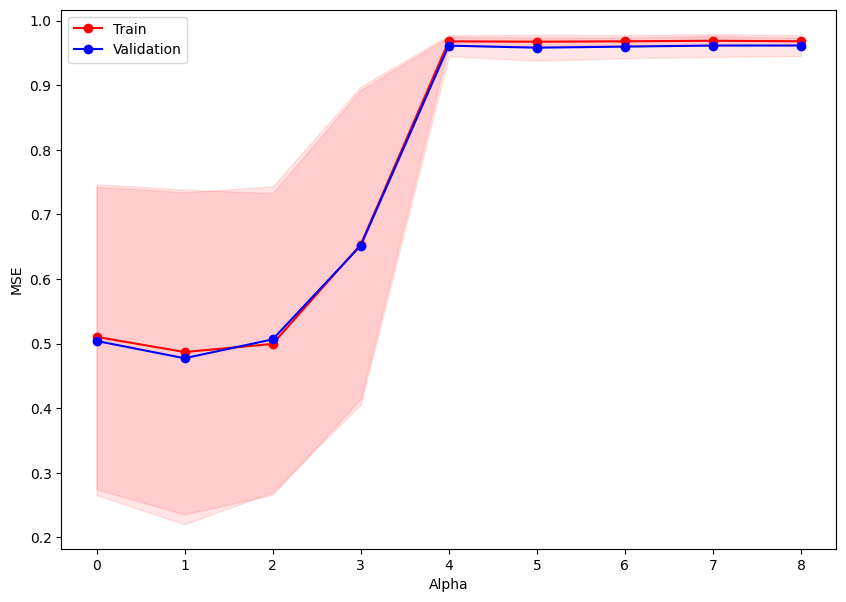

In [ ]:
# arrays into data frame
score_train_LogR_cancer = pd.DataFrame((score_train_LogR_cancer).transpose())
score_valid_LogR_cancer = pd.DataFrame((score_valid_LogR_cancer).transpose())

plot_with_std(score_train_LogR_cancer, score_valid_LogR_cancer, 'Alpha')

Podemos observar que a partir de la 5ta alpha la desviación estandar es más pequeña y el accuracy mejora, por lo que elegiremos la última alpha para probar en el conjunto de validación.

## Cáncer de seno con naive Bayes

In [ ]:
repes = 1
k = 5

to_test =[MultinomialNB(), GaussianNB(),  BernoulliNB()]

accuracy_train = np.zeros((len(to_test), 10*k))
accuracy_test  = np.zeros((len(to_test), 10*k))

for i in range(len(to_test)):
  model = make_pipeline( MinMaxScaler(), to_test[i] )
  k_fold = RepeatedKFold(n_splits = k, random_state = 0)

  scores = cross_validate(model, X_train, Y_train,
                          scoring= 'accuracy',
                          cv = k_fold,
                          return_train_score = True,
                          error_score='raise')

  accuracy_train[i][:] = scores['train_score']
  accuracy_test[i][:]  = scores['test_score']

#into a data frame
df_accuracy_train = pd.DataFrame(accuracy_train.T, columns= ['MultinomialNB()', 'GaussianNB()',  'BernoulliNB()'])
df_accuracy_test = pd.DataFrame(accuracy_test.T, columns= ['MultinomialNB()', 'GaussianNB()',  'BernoulliNB()'])

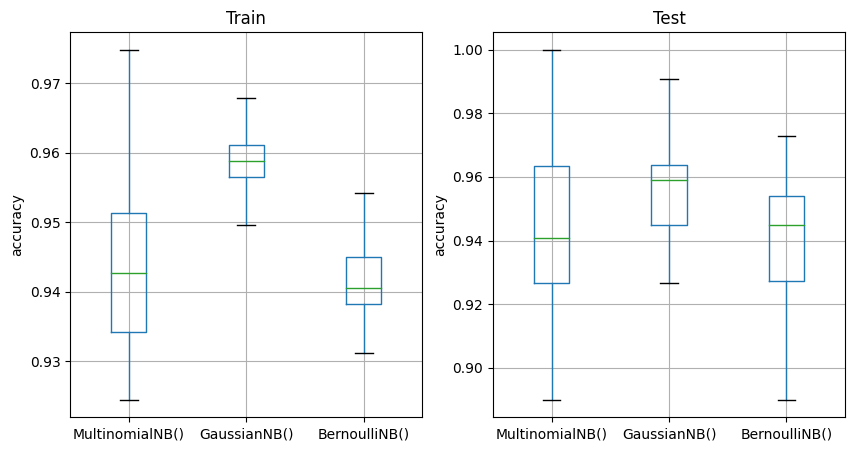

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
df_accuracy_train.boxplot()
plt.ylabel('accuracy')
plt.title('Train')

plt.subplot(1, 2, 2)
df_accuracy_test.boxplot()
plt.ylabel('accuracy')
plt.title('Test')

plt.show()

Tanto en el conjunto de validación como en el de entrenamienoto el accuracy es mejor para el GaussianNB, sin embargo podemos observar que para los tres calsificadore utilizados la desviación estandar en ambos conjuntos es muy grande, lo que podría indicar falta de generalización. Elegiremos GaussianNB como el mejor modelo NB.

## Evaluación en el conjunto de validación
Probaremos el mejor modelo en el conjunto de validación

In [ ]:
# Naive Bayes
model = make_pipeline( MinMaxScaler(), GaussianNB())
model.fit(X_test, Y_test)
model.score(X_test, Y_test)


0.9708029197080292

In [ ]:
# regresión logistica

best_alpha = alphas[-1]

model = make_pipeline( MinMaxScaler(), LogisticRegression(n_iter, alp))
model.fit(X_test, Y_test)
model.score(X_test, Y_test)

0.9927007299270073

En ambos modelos se encuentra un accuracy bastante bueno, sin embargo recordando que el desemepeño para los clasificadores bayesiano presenta una gran desviación estandar usando cross validation, elegiremos como mejor modelo para este problema la regresión logistica con alpha 10⁹